In [1]:
import esg

In [2]:
import pandas as pd
import math

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white",
        palette="pastel",
        color_codes=True,
        rc={'figure.figsize':(12,8),
            'figure.dpi':500})

In [4]:
import dotenv, os

dotenv.load_dotenv()

data_path = os.path.join("..", os.environ.get("DATA_PATH"))

esg_path = os.path.join(data_path, "ESG.xlsx")
sheet_name = os.environ.get("SHEET_NAME")

own_path = os.path.join(data_path, "ownership.csv")

In [5]:
raw = pd.read_excel(esg_path, sheet_name = sheet_name)

get_esg = esg.yearly_esg_maker(raw)

In [6]:
def pct_to_num(pct) -> float:
    """
    Convert 1% to 0.01
    """
    if type(pct) == str:
        return float(pct.replace("%", "")) / 100

    return pct

def parseownershipdata(raw):
    df = raw.dropna(axis = 0, how = 'all').dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')

    investors = df.columns[-7:]
    for investor in investors:
        df[investor] = df[investor].apply(pct_to_num)

    return df

In [7]:
ownership = parseownershipdata(pd.read_csv(own_path))
investors = ownership.columns[-7:]

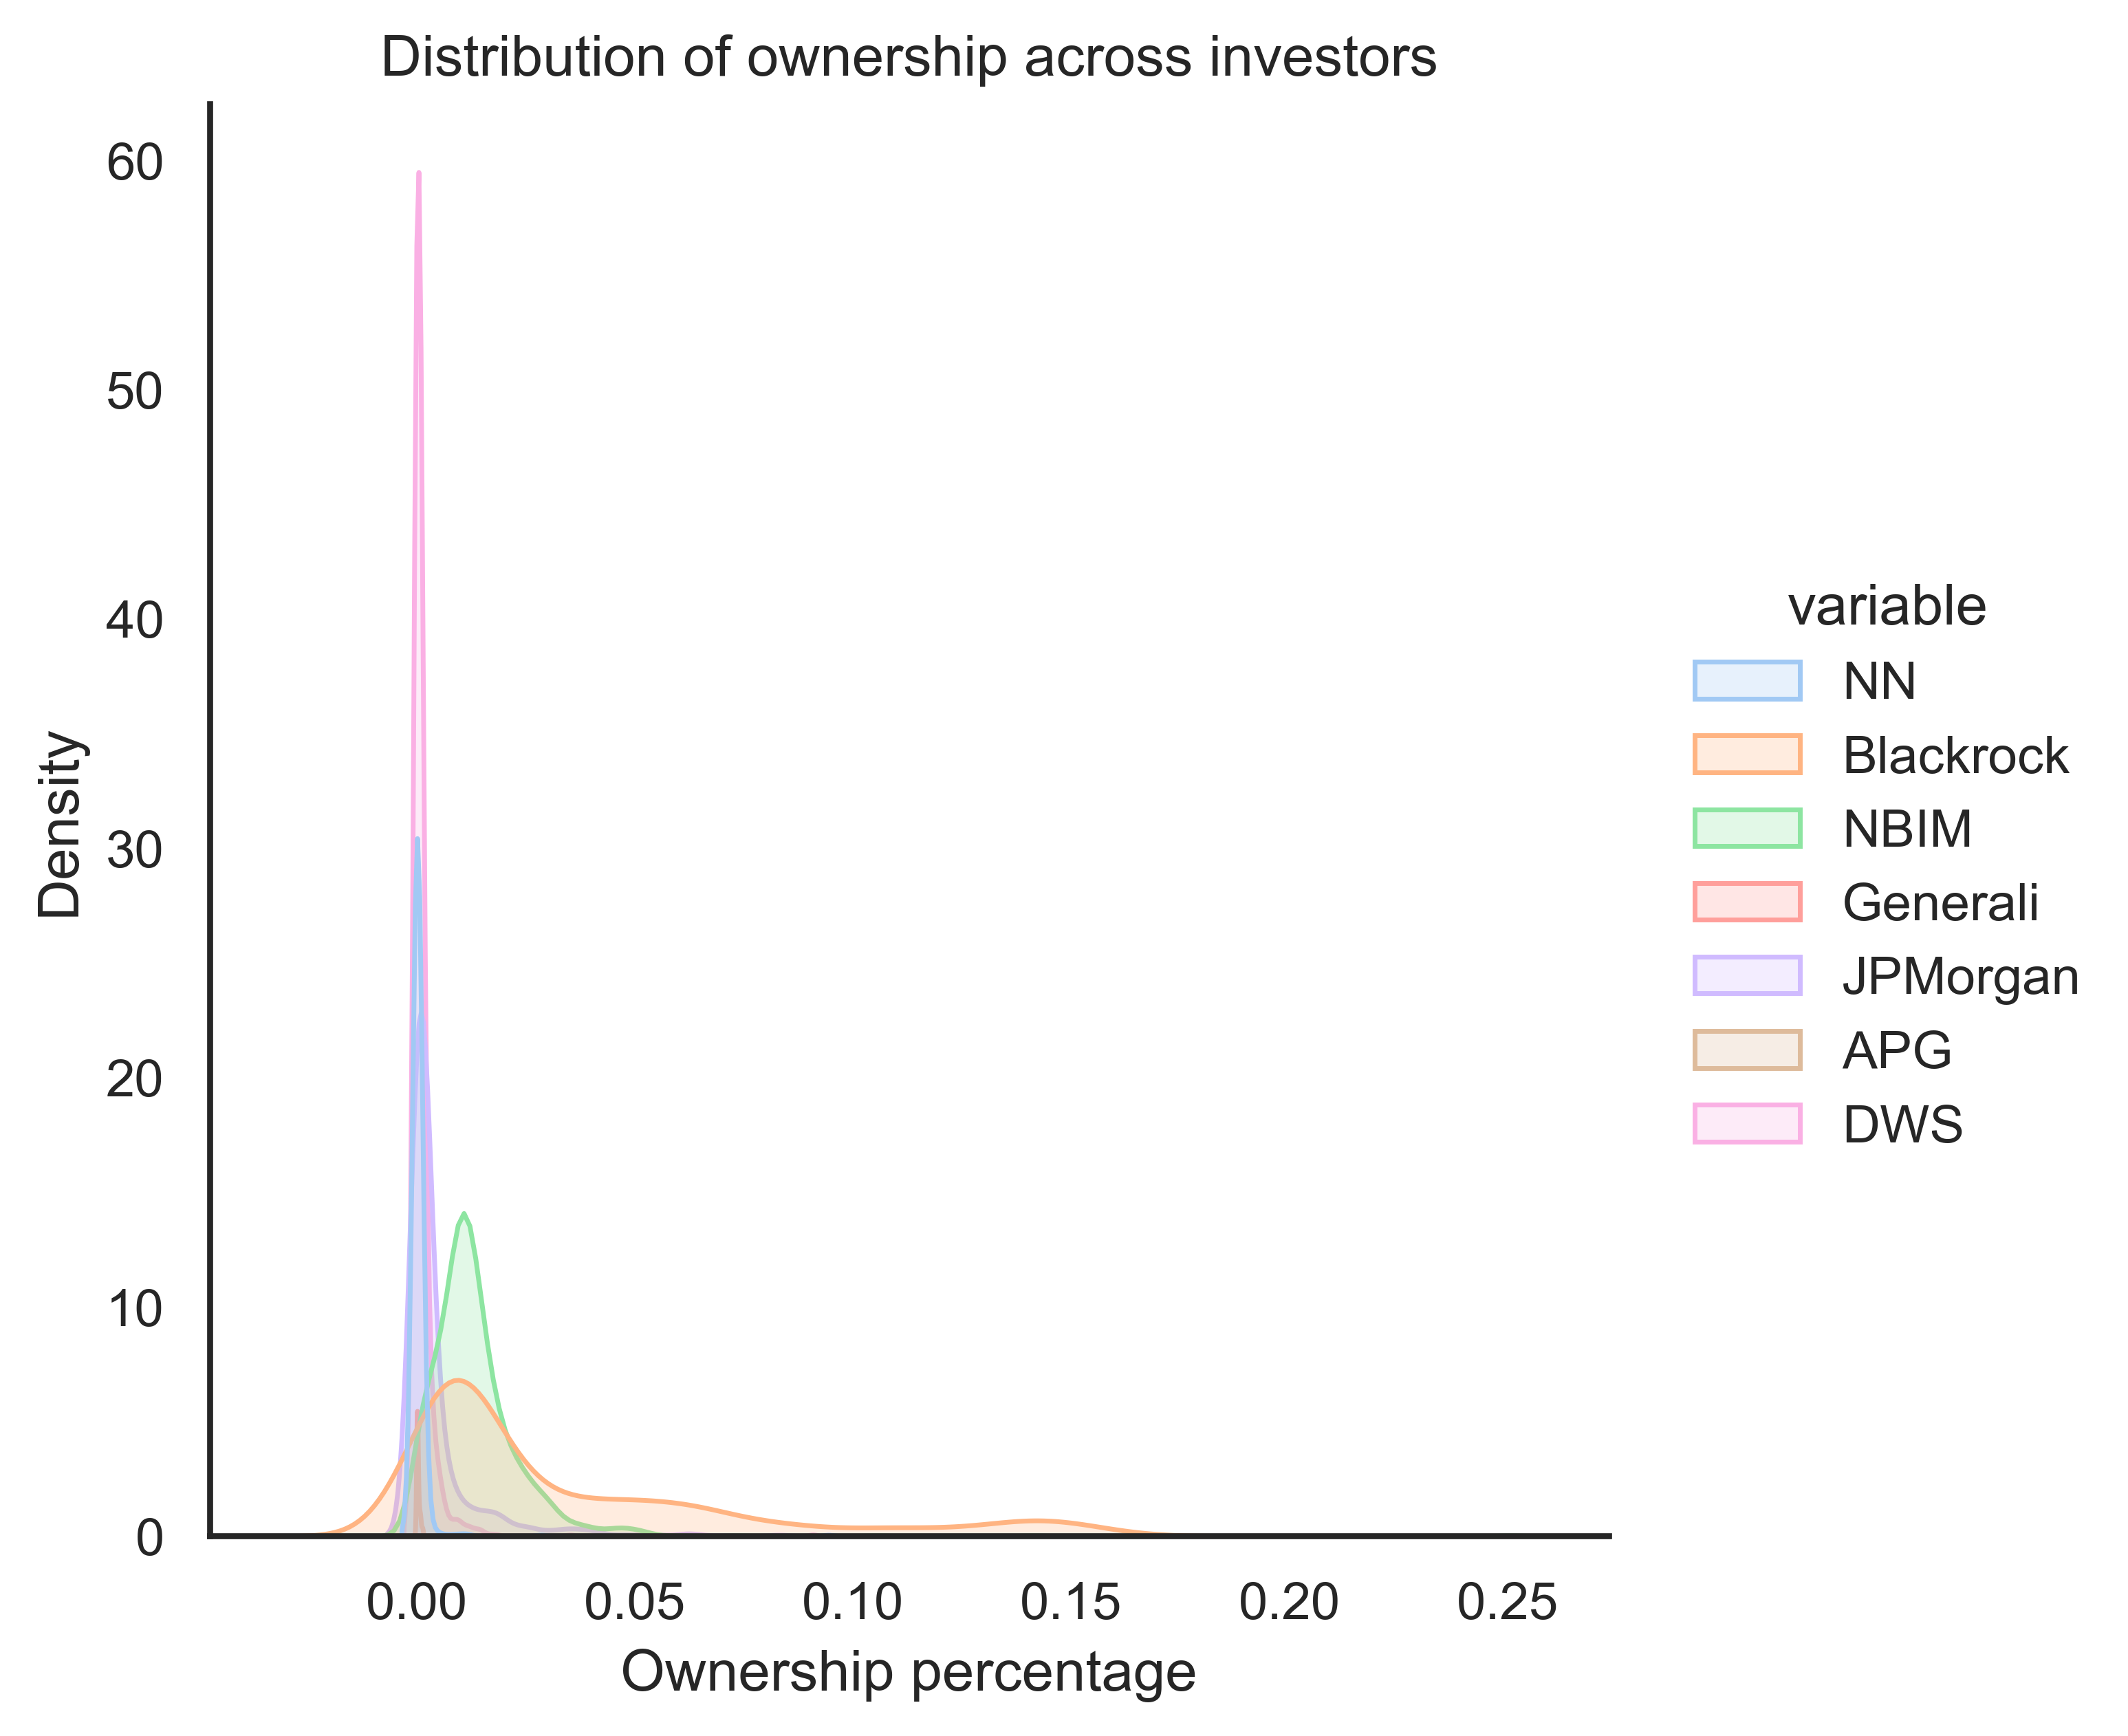

In [18]:
nonzerodf = ownership[investors].melt()
nonzerodf = nonzerodf[nonzerodf['value'] > 0]

sns.displot(data = nonzerodf, x = 'value', hue = 'variable', kind='kde', fill=True)
plt.title("Distribution of ownership across investors")
plt.xlabel("Ownership percentage")

plt.savefig('plots/ownership_density.jpg')